<a href="https://colab.research.google.com/github/fjpcediel87/DeepLearning--Learning/blob/main/06_Data_Augmentation_Regu_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying CIFAR10 images using a ResNet and Regularization techniques in PyTorch
### AKA Train an image classifier from scratch to over 90% accuracy in less than 10 minutes

This notebook is an extension to the tutorial [**Image Classification using CNNs in PyTorch**](https://jovian.ml/aakashns/05-cifar10-cnn), where we trained a deep convolutional neural network to classify images from the CIFAR10 dataset with around 55% accuracy. In this tutorial, we'll use the following techniques to achieve over 90% accuracy in less than 10 minutes:
* Data normalization
* Data augmentation
* Residual connections
* Batch normalization
* Learning rate annealing
* Weight Decay
* Gradient clipping



In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
torch.cuda.is_available()

True

In [3]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

data_dir = './data/cifar10'

# Look inside the dataset directory
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

100.0%
C:\Users\jeari\AppData\Local\Temp\ipykernel_16748\3866484377.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path='./data')


['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


There are a few of important changes we'll make while creating the PyTorch datasets:

1. Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with.

2. We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3. We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg

In [4]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [6]:
batch_size = 400

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, shuffle=False,
                      num_workers=3, pin_memory=True)

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], 8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


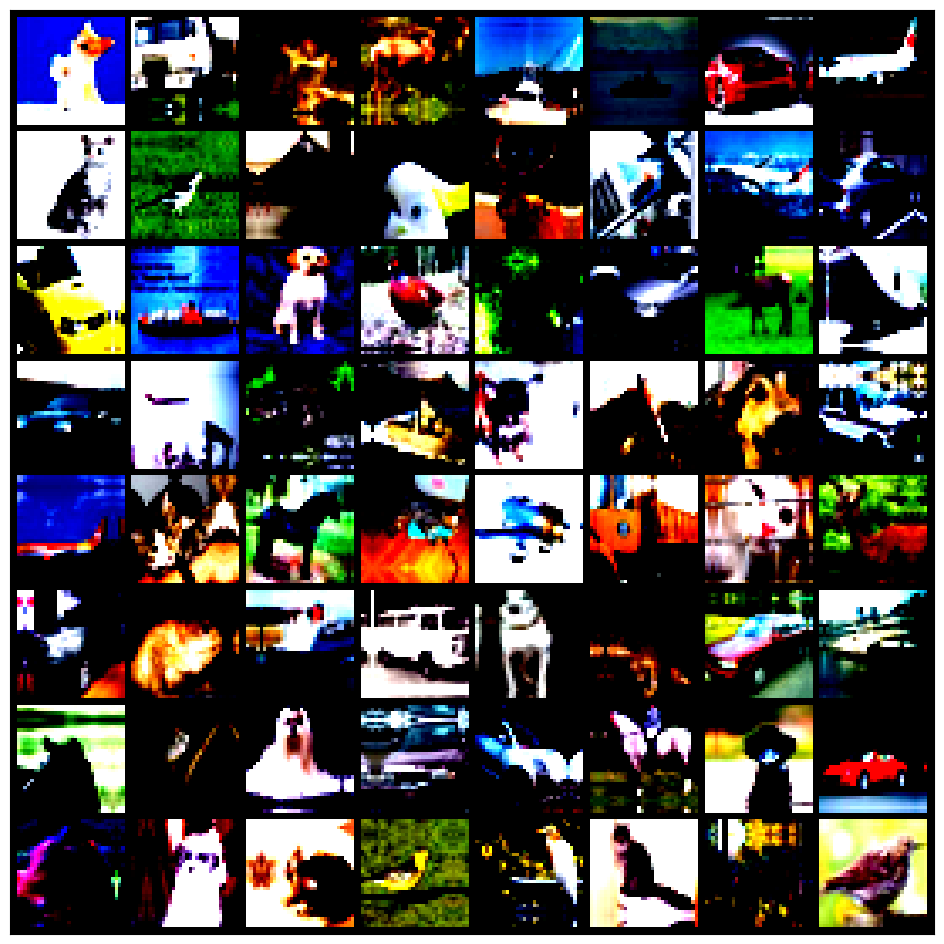

In [9]:
show_batch(train_dl)

# Using GPU

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device= get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


## Model with Residual Blocks and Batch Normalization

We'll use a significatly larger model this time, called the WideResNet22, which has 22 convolutional layers. However, one of the key changes to our model is the addition of the **resudial block**, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

<img src="https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png">

Here is a very simply Residual block:

In [13]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        #Please note in_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x #This is the Res Block, ReLU can be applied before or after adding the input Ex: self.relu2(out + x)

In [14]:
simple_resnet = to_device(SimpleResidualBlock(),device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break


del simple_resnet, images, labels
torch.cuda.empty_cache()


torch.Size([400, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Here's a great blog post explaining why and how residual blocks work:https://medium.com/data-science/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

(this link will lead you to a different website)
 https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec .

Also, after each convolutional layer, we'll add a batch normalization layer. Here's a good explanation of batch normalization: https://medium.com/data-science/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd


We'll define a series of helper functions to create:



1.   the ResNet 9 network, whic has the following structure:
![](https://www.researchgate.net/publication/373047175/figure/fig3/AS:11431281192043321@1695697738236/ResNet-9-on-CIFAR-10-measurement-results-a-Network-architecture-ResNet-9-comprises.png)

2.   the WideResNet22 network, which has the following structure:


<img src="https://miro.medium.com/max/2500/1*gOyiFYGHMAEDlyoAIhkWkA.png">

As in the previous session, let's create `ImageClassificationBase`

In [79]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# ResNet9

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64) # 64 x 32 x 32
        self.conv2 = conv_block(64,128, pool = True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128)) #128 x 16 x 16

        self.conv3 = conv_block(128,256, pool = True) # 256 x 8 x 8
        self.conv4 = conv_block(256,512, pool = True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512)) # 512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4), #512 x 1 x 1
                                        nn.Flatten(),   #512
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [17]:
model_ResNet9 = to_device(ResNet9(3, 10), device)
model_ResNet9

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

In the previous tutorials, we defined helper functions to train the model. This time, we'll use some functions from the FastAI library, which builds on top of PyTorch and offers many utilities, including a powerful & customizable training loop with learning rate scheduling.

Learning rate scheduling refers to the process of dynamically changing the learning rate while the model is being trained. There are many strategies for changing the learning rate during training, and the one we'll use is called the 1-cycle policy. We start out with a low learning rate, then gradually increase it linearly to high value for about half of the training, and then slowly bring it to the original value. At the end, we train for few iterations with a very low learning rate.

<img src="https://sgugger.github.io/images/art5_lr_schedule.png">

Here's a great explanation of the 1-cycle policy: https://sgugger.github.io/the-1cycle-policy.html

Another concept to be implemented is Gradient clipping, which will limit the gradient in case it is too large.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*vLFINWklJ0BtYtgzwK223g.png)

https://medium.com/data-science/what-is-gradient-clipping-b8e815cdfb48




In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  #Set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gracient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record & update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [19]:
history = [evaluate(model_ResNet9, valid_dl)]
history

[{'val_loss': 2.3035082817077637, 'val_acc': 0.10384615510702133}]

In [20]:
epocs=8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [21]:
%%time
history += fit_one_cycle(epocs, max_lr, model_ResNet9, train_dl, valid_dl
                        , grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.3051, val_loss: 1.2151, val_acc: 0.5828
Epoch [1], last_lr: 0.00935, train_loss: 0.9888, val_loss: 1.3132, val_acc: 0.6152
Epoch [2], last_lr: 0.00972, train_loss: 0.8085, val_loss: 0.6870, val_acc: 0.7596
Epoch [3], last_lr: 0.00812, train_loss: 0.5899, val_loss: 0.4966, val_acc: 0.8318
Epoch [4], last_lr: 0.00556, train_loss: 0.4613, val_loss: 0.5086, val_acc: 0.8217
Epoch [5], last_lr: 0.00283, train_loss: 0.3521, val_loss: 0.3620, val_acc: 0.8767
Epoch [6], last_lr: 0.00077, train_loss: 0.2567, val_loss: 0.2932, val_acc: 0.8994
Epoch [7], last_lr: 0.00000, train_loss: 0.1894, val_loss: 0.2752, val_acc: 0.9064
CPU times: total: 30.3 s
Wall time: 12min 18s


In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

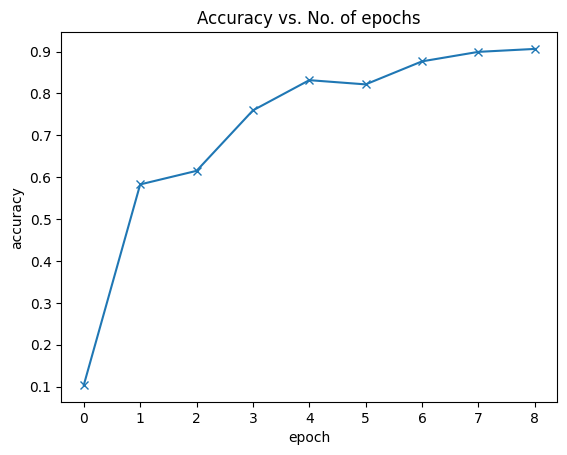

In [23]:
plot_accuracies(history)

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

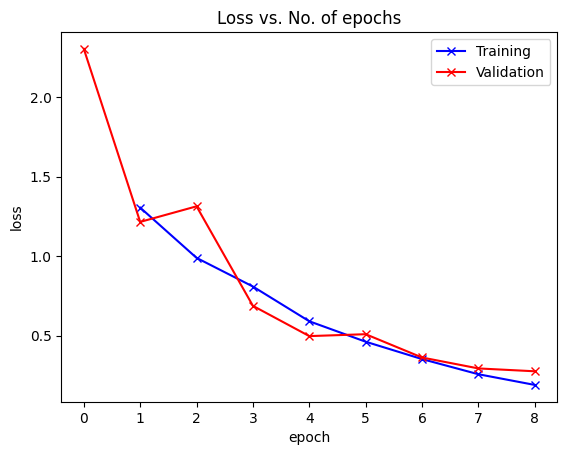

In [25]:
plot_losses(history)

In [28]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');   

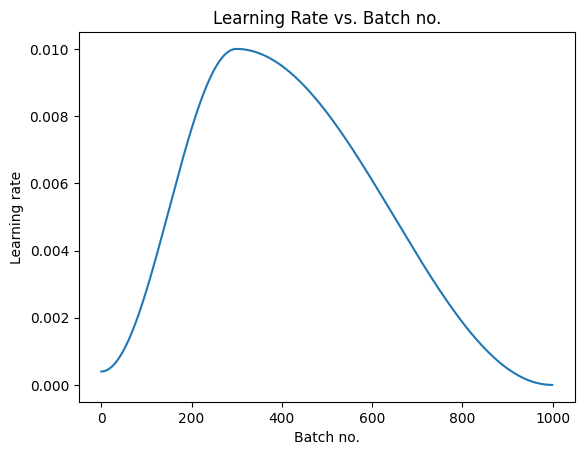

In [29]:
plot_lrs(history)

In [30]:
torch.save(model_ResNet9.state_dict(), 'cifar10-resnet9.pth')

## Testing

In [37]:
from torchvision.transforms import ToTensor
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
test_dataset = ImageFolder(data_dir+'/test', test_tfms)

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8116769..2.7537313].


Label: airplane , Predicted: ship


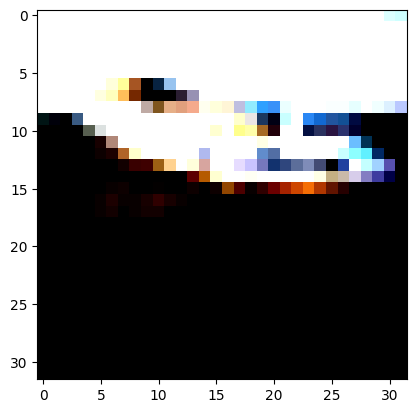

In [57]:
img, label = test_dataset[15]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model_ResNet9))

# WideResNetwork22

In [63]:
n_start = 16
k=6
n_channels = [n_start]
for i in range(3):
    n_channels.append(n_start*(2**i)*k)
    print(f"iteration: {i}, channels: {n_channels}")

iteration: 0, channels: [16, 96]
iteration: 1, channels: [16, 96, 192]
iteration: 2, channels: [16, 96, 192, 384]


In [80]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(ImageClassificationBase):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [81]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(ImageClassificationBase):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(ImageClassificationBase):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [82]:
model = to_device(wrn_22(),device)

In [83]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([400, 3, 32, 32])
out.shape: torch.Size([400, 10])


In [84]:
history2 = [evaluate(model, valid_dl)]
history2

[{'val_loss': 2.304271697998047, 'val_acc': 0.09615384787321091}]

In [85]:
epocs=8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [87]:
%%time
history2 += fit_one_cycle(epocs, max_lr, model, train_dl, valid_dl
                        , grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.4415, val_loss: 1.5497, val_acc: 0.4903
Epoch [1], last_lr: 0.00935, train_loss: 1.0268, val_loss: 1.3948, val_acc: 0.5348
Epoch [2], last_lr: 0.00972, train_loss: 0.8311, val_loss: 0.9756, val_acc: 0.6455
Epoch [3], last_lr: 0.00812, train_loss: 0.6900, val_loss: 0.7349, val_acc: 0.7552
Epoch [4], last_lr: 0.00556, train_loss: 0.5809, val_loss: 0.6248, val_acc: 0.7896
Epoch [5], last_lr: 0.00283, train_loss: 0.4704, val_loss: 0.4371, val_acc: 0.8487
Epoch [6], last_lr: 0.00077, train_loss: 0.3598, val_loss: 0.3344, val_acc: 0.8832
Epoch [7], last_lr: 0.00000, train_loss: 0.2742, val_loss: 0.3118, val_acc: 0.8932
CPU times: total: 5min 26s
Wall time: 1h 10min 26s
